### 0. Set up the environment

In [ ]:
# Setup environment
using Pkg
Pkg.add("IceFloeTracker")
Pkg.add("DelimitedFiles")

#### Recommened Settings
1. Install Julia
2. Install VS Code
3. Add the following extensions for VS Code: Julia, Jupyter
4. (Optional) Ensure Julia is set up to work with threading enabled for shared memory multiprocessing.
   a. Press Cmd+Shift+P (mac) or Ctrl+Shift+P (windows) to display the command palette and search for `settings.json` and choose the option that appears
   
    ![Open the settings.json file using Cmd+Shift+P (mac) or Ctrl+Shift+P (windows) to display the command palette and search for `settings.json`](imgs/settings.png)
    
   b. In the `settings.json` file, find the ` "julia.NumThreads"` option (near the bottom). Change its value to `"auto"` and save the file
   
   ![find the "julia.NumThreads" option and change its value to "auto"](imgs/set-threads-auto.png)

### 1. Activate the IceFloeTracker package

First activate the project environment, load things, and set up some paths.

In [63]:
# The notebook presently uses test images and some testing tools from the test directory.
HOME = "../.." # path to the root of the project two levels up
TEST = joinpath(HOME, "test") # path to the folder with tests, test inputs, and test outputs

# Load packages
using Images: float64, @test_approx_eq_sigma_eps, load, Gray
using DelimitedFiles # for loading test data in csv format
using IceFloeTracker
using IceFloeTracker.LopezAcosta2019: imsharpen, imsharpen_gray, normalize_image, discriminate_ice_water, segmentation_A, segmentation_B, segmented_ice_cloudmasking, segmentation_F, watershed_ice_floes, watershed_productusing Distributed # for parallel processing
using Images: mosaicview, strel_box, adjust_histogram, AdaptiveEqualization, complement, mreconstruct, dilate
addprocs(1) # add a single worker process for watershed computation
include(joinpath(TEST,"config.jl")) # loads some test data paths
include(joinpath(TEST,"test_error_rate.jl")) # loads the `test_error_rate` function

test_similarity (generic function with 2 methods)

## 1. Landmask generation
It is often useful to separate ocean and land pixels in remote sensing image analysis. Here, we use a land mask from OpenStreetMap. We convert the RGB image into a bitmatrix (0s and 1s). In addition, pixels near the coast often are different enough from ocean pixels to cause problems in algorithms. Hence, we produce a dilated (expanded) land mask to cover these problem areas. We do this using a "structuring element" - an array containing a shape such as a disk or box. Morphological dilation takes a structuring element, moves it over every pixel of an image, and replaces the pixel with the maximum of all the pixels in the box. The effect is to "spread out" bright areas in the black-and-white image.

  0.804833 seconds (653.89 k allocations: 825.467 MiB, 33.80% gc time)
  3.218919 seconds (88 allocations: 146.806 MiB, 0.09% gc time)


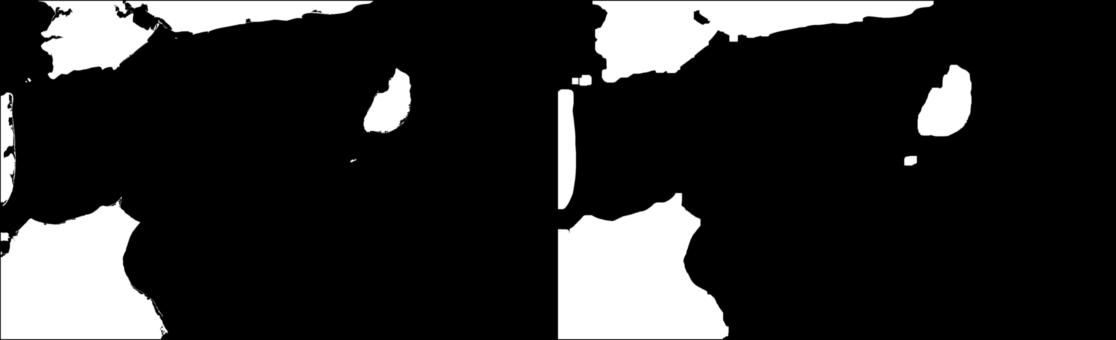

In [65]:
# 1. Load coastline The test images are very large, so we'll just load a subset
test_region = (1:2707, 1:4458)
@time coastline = load(joinpath(TEST, "./test_inputs/landmask.tiff"))[test_region...];

# 2. Create landmask
@time landmask_imgs = IceFloeTracker.create_landmask(coastline, strel_box((51,51)));

# Display the land masks. Using "Gray" tells Julia to interpret the array of 0's and 1's as an image.
mosaicview(Gray.(landmask_imgs.non_dilated), Gray.(landmask_imgs.dilated), nrow=1)

## 2. Preprocessing

Next, we will load a pair of MODIS images and apply preprocessing routines to prepare the images for ice floe identification. The true color image uses MODIS bands 1, 4, and 3 (red, green, blue) and approximates the scene perceived by a human eye. The false color image uses MODIS bands 7, 2, and 1 (near infrared, shortwave infrared, and red). The colors produced here make it easier to distinguish clouds from snow and ice.

  2.984894 seconds (996.18 k allocations: 1.416 GiB, 1.86% gc time, 1.31% compilation time)
  2.727809 seconds (1.00 M allocations: 1.373 GiB, 10.15% gc time, 1.42% compilation time)


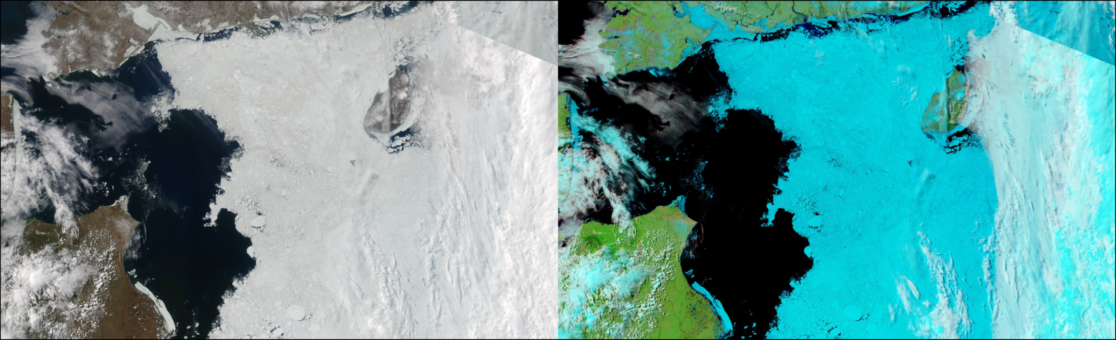

In [66]:
# 1. Load test data. The 

falsecolor_test_image_file = "test_inputs/beaufort-chukchi-seas_falsecolor.2020162.aqua.250m.tiff"
@time falsecolor_image = load(joinpath(TEST,falsecolor_test_image_file))[test_region...] |> x->float64.(x) # load and convert to float64

truecolor_test_image_file = "test_inputs/beaufort-chukchi-seas_truecolor.2020162.aqua.250m.tiff"
@time truecolor_image = load(joinpath(TEST,truecolor_test_image_file))[test_region...] |> x->float64.(x);

# View the images we just loaded:
mosaicview(truecolor_image, falsecolor_image, nrow=1)

We can use the false color image to automatically identify likely cloud pixels. The IFT package contains two cloud mask algorithms. Here, we'll show the `LopezAcostaCloudMask`, which only masks the brightest clouds, so that ice floes visible through thin clouds remain uncovered.

  0.150417 seconds (51 allocations: 689.033 MiB, 2.94% gc time)


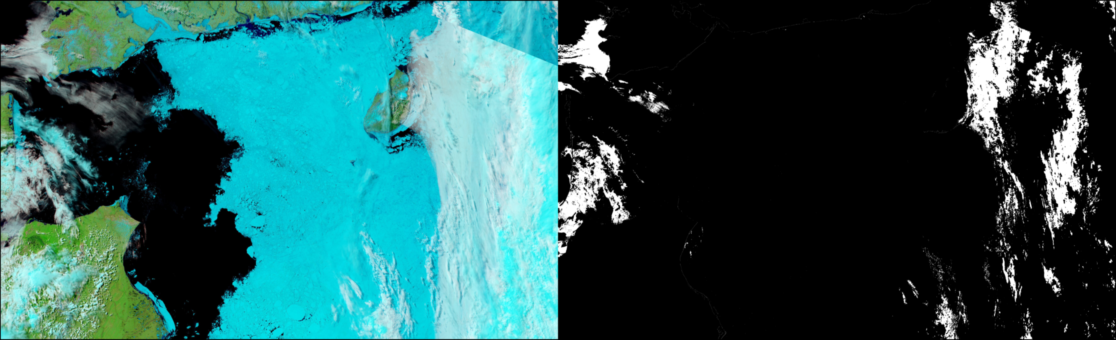

In [67]:
# set parameters for cloudmask
prelim_threshold = Float64(110 / 255)
band_7_threshold = Float64(200 / 255)
band_2_threshold = Float64(190 / 255)
ratio_lower = 0.0
ratio_offset = 0.0
ratio_upper = 0.75

# Create cloudmask from reflectance image
@time cloudmask = create_cloudmask(falsecolor_image,
        LopezAcostaCloudMask(prelim_threshold,
                             band_7_threshold,
                             band_2_threshold,
                             ratio_lower,
                             ratio_offset,
                             ratio_upper));

# This cloudmask is only validated over ocean and ice, so we should mask any land pixels
IceFloeTracker.apply_landmask!(cloudmask, landmask_imgs.non_dilated)

mosaicview(falsecolor_image, Gray.(cloudmask), nrow=1) # cloud is white

### 3. Create intermediate images for segmentation
In this section, we create a grayscale image with enhanced contrast at ice floe edges and reduced contrast within ice floes, and we even out the lighting across the image. Then, we will use grayscale morphological operations and threshold functions to brighten large ice floes and darken the interstitial ice. 

 12.781519 seconds (2.00 k allocations: 28.608 GiB, 23.86% gc time)


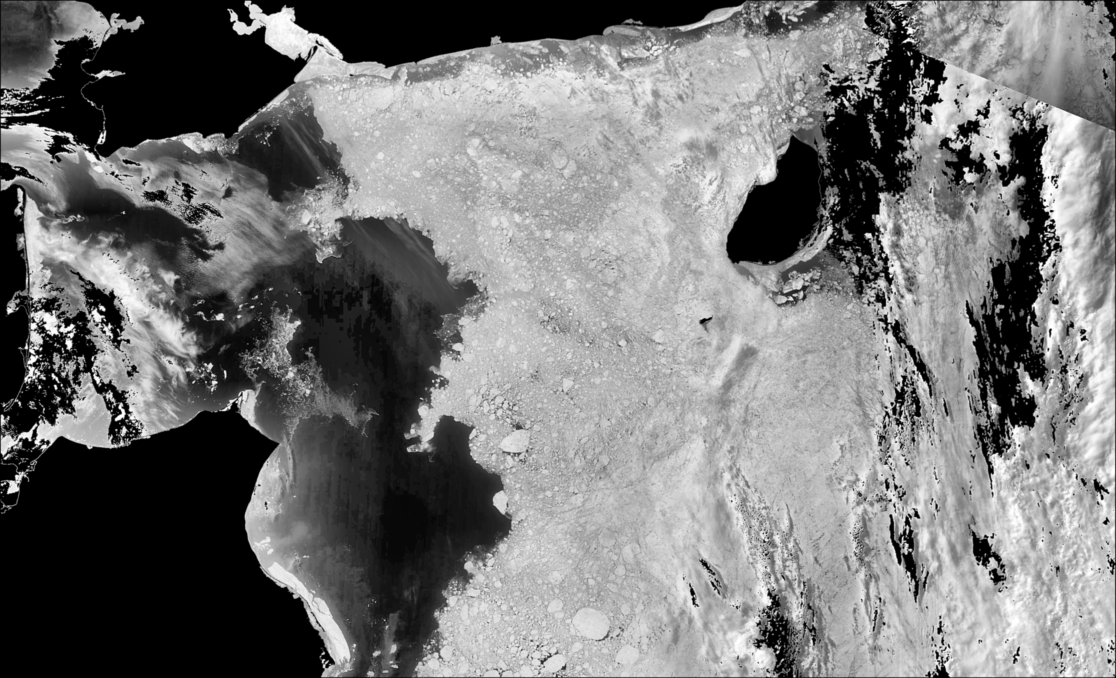

In [68]:
# 1. Nonlinear diffusion using the Perona-Malik algorithm
truecolor_masked = IceFloeTracker.apply_landmask(truecolor_image, landmask_imgs.non_dilated)
truecolor_masked .= IceFloeTracker.apply_cloudmask(truecolor_masked, cloudmask)
pmd = IceFloeTracker.PeronaMalikDiffusion(0.1, 0.1, 5, "exponential")
@time truecolor_diffused = IceFloeTracker.nonlinear_diffusion(truecolor_masked, pmd)

# 2. Adaptive histogram equalization
truecolor_equalized = adjust_histogram(truecolor_diffused,
                      AdaptiveEqualization(nbins=256, rblocks=8, cblocks=8, clip=0.9))

# 3. Unsharp Mask and Convert to Grayscale
preprocessed_image = Gray.(IceFloeTracker.unsharp_mask(truecolor_equalized))


To see the effect of the preprocessing steps, we zoom in to a region with sea ice floes, and show (clockwise from top left) the original truecolor image, the result of nonlinear diffusion, the adaptive histogram equalization, and the sharpened grayscale image.

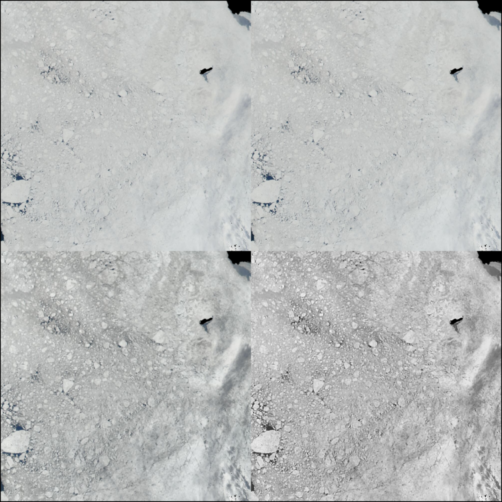

In [69]:

# 4. Visualize results. Mosaicview defaults to columns first then rows, hence the order of images here.
zoom_region = (1000:2000, 2000:3000)
mosaicview(truecolor_masked[zoom_region...],
           truecolor_equalized[zoom_region...],
           truecolor_diffused[zoom_region...],
           preprocessed_image[zoom_region...], nrow=2)

In [27]:
#= ice labels
   This output contains a vector of pixel indexes where there is obvious ice.=#
band_7_max = 5 / 255
band_2_min = 230 / 255
band_1_min = 240 / 255
band_7_max_relaxed = 10 / 255
band_1_min_relaxed = 190 / 255
possible_ice_threshold = 75 / 255

@time ice_labels = find_ice_labels(
   falsecolor_image,
   landmask_imgs.dilated;
   band_7_max,
   band_2_min,
   band_1_min,
   band_7_max_relaxed,
   band_1_min_relaxed,
   possible_ice_threshold,
);

  0.210628 seconds (57 allocations: 1.129 GiB, 13.11% gc time)


Enhancing contrast between ice floes and leads

  0.566995 seconds (7.01 k allocations: 395.028 MiB, 1.12% gc time)
  0.631984 seconds (72 allocations: 948.195 MiB, 40.29% gc time)


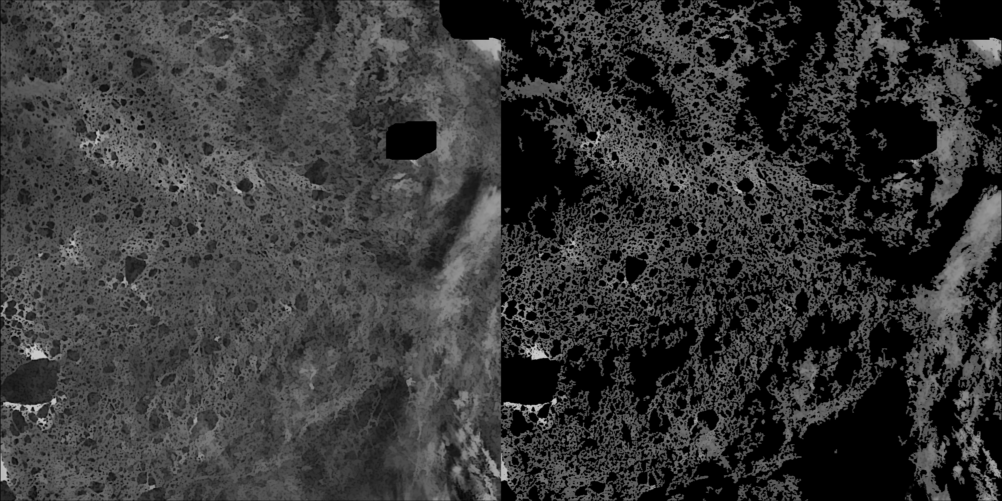

In [56]:
# Grayscale reconstruction of the complement smooths the interstial ice
@time  begin
    markers = complement.(dilate(preprocessed_image, strel_box((5,5))))
    mask = complement.(preprocessed_image)
    # reconstruction of the complement: floes are dark, leads are bright
    reconst_gray = mreconstruct(dilate, markers, mask, strel_box((3, 3)))
    IceFloeTracker.apply_landmask!(reconst_gray, landmask_imgs.dilated)
end

# Histogram-based enhancement of ice/water contrasts
floes_threshold = 100 / 255
mask_clouds_lower = 17 / 255
mask_clouds_upper = 30 / 255
kurt_thresh_lower = 2
kurt_thresh_upper = 8
skew_thresh = 4
st_dev_thresh_lower = 84 / 255
st_dev_thresh_upper = 98.9 / 255
clouds_ratio_threshold = 0.02
differ_threshold = 0.6
nbins = 155

@time ice_water_discrim = discriminate_ice_water(
    falsecolor_image, reconst_gray, copy(landmask_imgs.dilated), # pass a copy of landmask
    cloudmask, floes_threshold, mask_clouds_lower, mask_clouds_upper, kurt_thresh_lower, kurt_thresh_upper, skew_thresh, st_dev_thresh_lower, st_dev_thresh_upper, clouds_ratio_threshold, differ_threshold, nbins)


mosaicview(reconst_gray[zoom_region...], ice_water_discrim[zoom_region...], nrow=1)

## 4. Segmentation

In [ ]:
# segmentation_A
@time segA = segmentation_A(segmented_ice_cloudmasking(
    ice_water_discrim, cloudmask, ice_labels
));
# Takes about 10 seconds

 10.589016 seconds (38.47 M allocations: 6.935 GiB, 4.25% gc time)


2702×4458 BitMatrix:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  1  1  1  1  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  1  1  1  1  1  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  1  1  1  1  1  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  1  1  1  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 ⋮              ⋮              ⋮        ⋱              ⋮              ⋮     
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1

(2702, 4458)

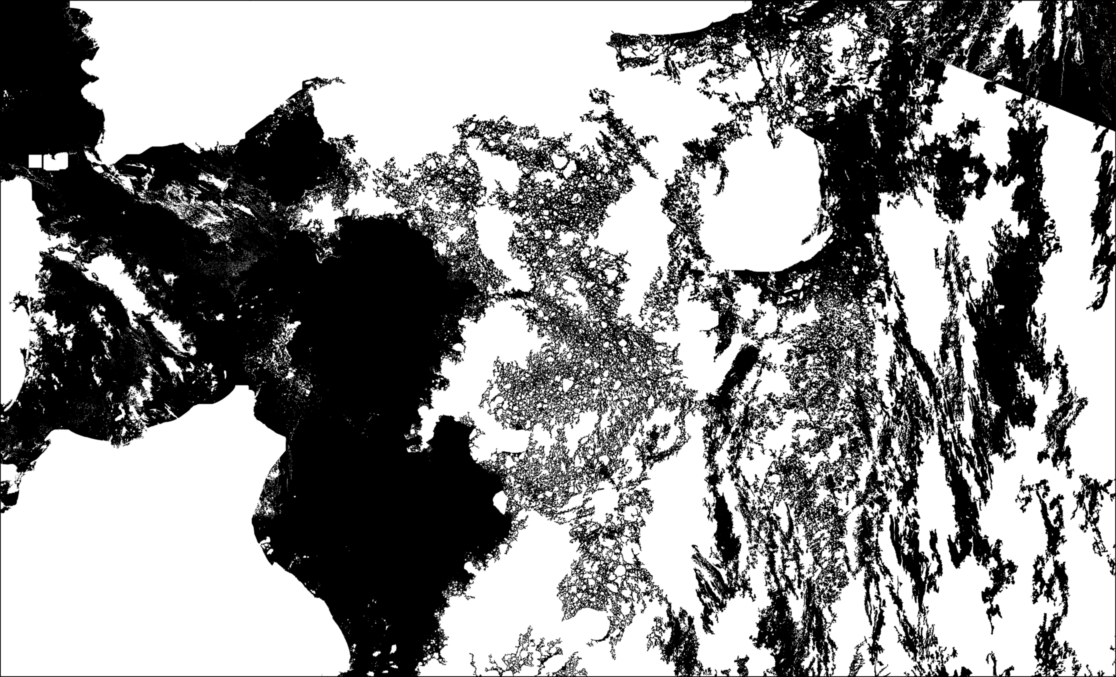

In [62]:
print(size(segA))
Gray.(segA)

(2707, 4458)

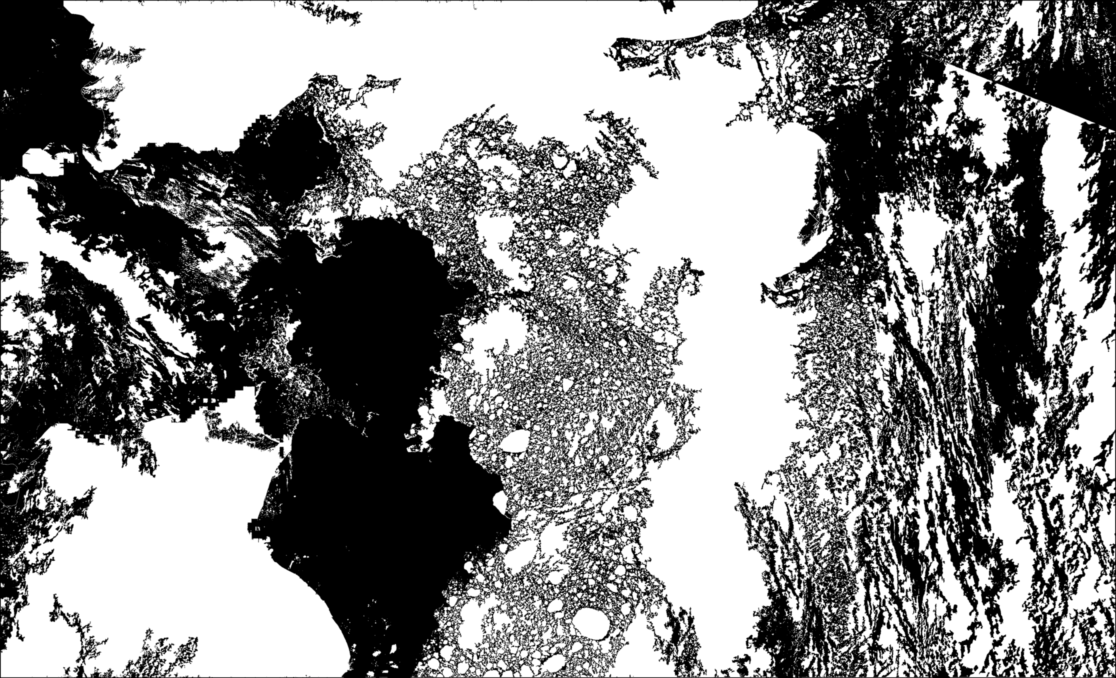

In [61]:
segA_expected = convert(BitMatrix,float64.(load(joinpath(TEST,"test_inputs/matlab_segmented_A.png"))))
print(size(segA_expected))
Gray.(segA_expected)

### Note
Here is the first significant source of differences between Julia and the original Matlab algorithm, introduced due to the implementation of the kmeans algorithm used for the package. For details see `src/segmentation_a_direct.jl` and/or https://juliastats.org/Clustering.jl/dev/kmeans.html#Clustering.kmeans.

In [60]:
# Test segmentation_A
# segA_expected = convert(BitMatrix,float64.(load(joinpath(TEST,"test_inputs/matlab_segmented_A.png"))))
# @assert test_similarity(segA_expected, segA, 0.1005)

In [ ]:
@time segB = segmentation_B(sharpened_gray_truecolor_image, cloudmask, segA)
# 1.264987 seconds (24.14 M allocations: 1.041 GiB, 0.36% compilation time)

In [ ]:
# Test segmentation_B
matlab_ice_intersect = convert(
        BitMatrix, load(joinpath(TEST,"test_inputs/matlab_segmented_c.png")
    ))

    matlab_not_ice_mask = float64.(load(joinpath(TEST,"test_inputs/matlab_I.png")))

@assert (@test_approx_eq_sigma_eps segB.not_ice matlab_not_ice_mask [0, 0] 0.055) === nothing
@assert test_similarity((matlab_not_ice_mask .> 0.499), segB.not_ice_bit, 0.05)
@assert test_similarity(matlab_ice_intersect, segB.ice_intersect, 0.08)

In [ ]:
segB.not_ice

In [ ]:
imshow(segB.not_ice_bit)

In [ ]:
imshow(segB.ice_intersect)

In [ ]:
# Generate watersheds
@time watersheds_segB = map(watershed_ice_floes, [segB.not_ice_bit, segB.ice_intersect])
# 423.326505 seconds (6.43 M allocations: 327.860 GiB, 8.08% gc time, 0.53% compilation time)

In [ ]:
watershed_intersect = watershed_product(watersheds_segB...)

In [ ]:
# Test watershed_intersect
matlab_watershed_D = convert(BitMatrix, load(joinpath(TEST,"test_inputs/matlab_watershed_D.png")))
matlab_watershed_E = convert(BitMatrix, load(joinpath(TEST,"test_inputs/matlab_watershed_E.png")))
matlab_watershed_intersect = convert(BitMatrix, load(joinpath(TEST,"test_inputs/matlab_watershed_intersect.png")))

## Tests with Matlab inputs
@assert test_similarity(matlab_watershed_D, watersheds_segB[1], 0.15)
@assert test_similarity(matlab_watershed_E, watersheds_segB[2], 0.15)
@assert test_similarity(matlab_watershed_intersect, watershed_intersect , 0.033)

In [ ]:
@time isolated_floes = segmentation_F(
    segB.not_ice,
    segB.ice_intersect,
    watershed_intersect,
    ice_labels,
    cloudmask,
    landmask_imgs.dilated,
)
# 445.557423 seconds (2.81 G allocations: 89.153 GiB, 2.79% gc time, 0.00% compilation time)

In [ ]:
# Test isolated_floes
matlab_BW7 = load(joinpath(TEST,"test_inputs/matlab_BW7.png")) .> 0.499

@assert test_similarity(matlab_BW7, isolated_floes, 0.143)

@assert test_similarity(matlab_BW7[ice_floe_test_region...], isolated_floes[ice_floe_test_region...], 0.071)


In [ ]:
imshow(isolated_floes)

In [ ]:
imshow(matlab_BW7)

In [ ]:
imshow(isolated_floes[ice_floe_test_region...])

In [ ]:
imshow(matlab_BW7[ice_floe_test_region...])